### **Loading Libraries**

In [ ]:
if(!require(quantmod)) install.packages("quantmod")
if(!require(forecast)) install.packages("forecast")
if(!require(xlsx)) install.packages("xlsx")
if(!require(timeSeries)) install.packages("timeSeries")
if(!require(dplyr)) install.packages("dplyr")
if(!require(tsfknn)) install.packages("tsfknn")
library(tidyverse)
library(quantmod)
library(forecast)
library("xlsx")
library(timeSeries)
library(dplyr)
library(tsfknn)
library(ggplot2 )

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::first()  masks xts::first()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::last()   masks xts::last()



### **Getting Stock Data**

In [ ]:
gsachs <- getSymbols("GS", src = "yahoo", from = "2016-01-01", to = as.character(Sys.Date()), auto.assign = FALSE)
dim(gsachs)
summary(gsachs)
tail(gsachs)

‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.




[1] 1152    6

     Index               GS.Open         GS.High          GS.Low     
 Min.   :2016-01-04   Min.   :136.0   Min.   :141.2   Min.   :130.9  
 1st Qu.:2017-02-23   1st Qu.:182.3   1st Qu.:184.9   1st Qu.:179.2  
 Median :2018-04-17   Median :215.4   Median :217.8   Median :213.3  
 Mean   :2018-04-16   Mean   :208.8   Mean   :211.0   Mean   :206.7  
 3rd Qu.:2019-06-10   3rd Qu.:234.5   3rd Qu.:236.0   3rd Qu.:232.4  
 Max.   :2020-07-30   Max.   :274.3   Max.   :275.3   Max.   :270.8  
    GS.Close       GS.Volume         GS.Adjusted   
 Min.   :135.0   Min.   :  467700   Min.   :130.6  
 1st Qu.:183.0   1st Qu.: 2306375   1st Qu.:180.1  
 Median :215.2   Median : 2900750   Median :208.8  
 Mean   :208.8   Mean   : 3329190   Mean   :200.6  
 3rd Qu.:233.9   3rd Qu.: 3811775   3rd Qu.:224.9  
 Max.   :273.4   Max.   :15194200   Max.   :261.7  

           GS.Open GS.High GS.Low GS.Close GS.Volume GS.Adjusted
2020-07-23  205.10  206.02 202.05   203.02   4088600      203.02
2020-07-24  203.00  204.93 201.32   201.47   3191500      201.47
2020-07-27  200.10  204.18 199.59   203.02   2601200      203.02
2020-07-28  201.91  203.60 201.09   201.62   2139600      201.62
2020-07-29  201.70  203.89 199.62   202.58   2635000      202.58
2020-07-30  199.50  199.99 196.30   199.53   3055300      199.53

###**Stock Return Behaviour using logarithm properties to calculate the log-return of the stock**

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.



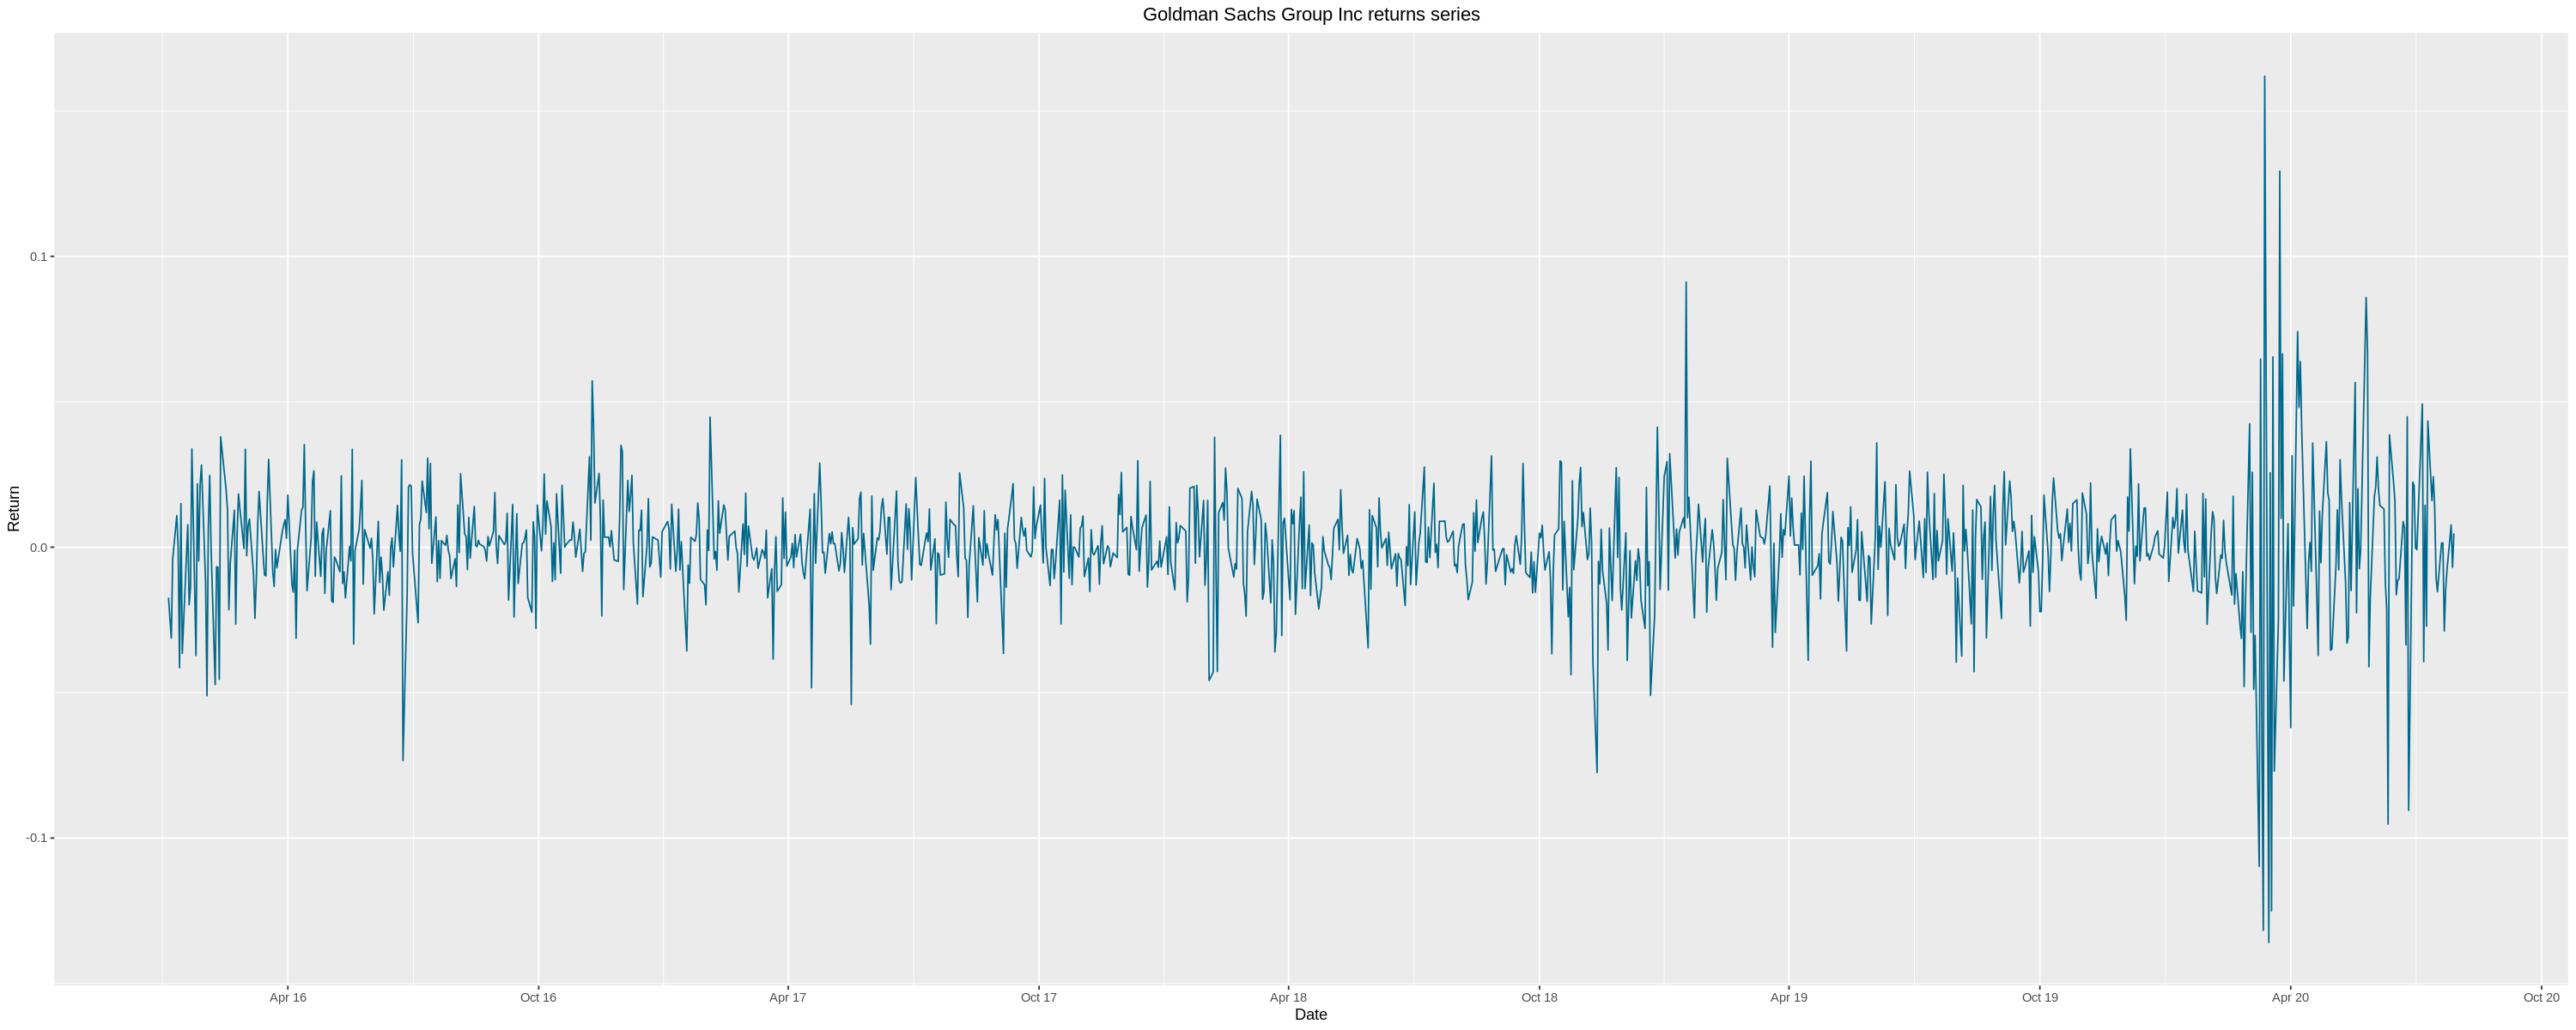

In [ ]:
gsachs_ret <- diff(log(gsachs[,6]))
gsachs_ret <- gsachs_ret[-1,]
options(repr.plot.width = 25, repr.plot.height = 10)
ggplot(gsachs_ret, aes(x = index(gsachs_ret), y = gsachs_ret)) +
  geom_line(color = "deepskyblue4") +
  ggtitle("Goldman Sachs Group Inc returns series") +
  xlab("Date") + ylab("Return") +
  theme(plot.title = element_text(hjust = 0.5)) + scale_x_date(date_labels = "%b %y", date_breaks = "6 months")

### **Forecasting Using ARIMA Model**

Series: Cl(gsachs) 
ARIMA(0,1,0) 
Box Cox transformation: lambda= 1.999924 

sigma^2 estimated as 610540:  log likelihood=-9291.99
AIC=18585.97   AICc=18585.98   BIC=18591.02

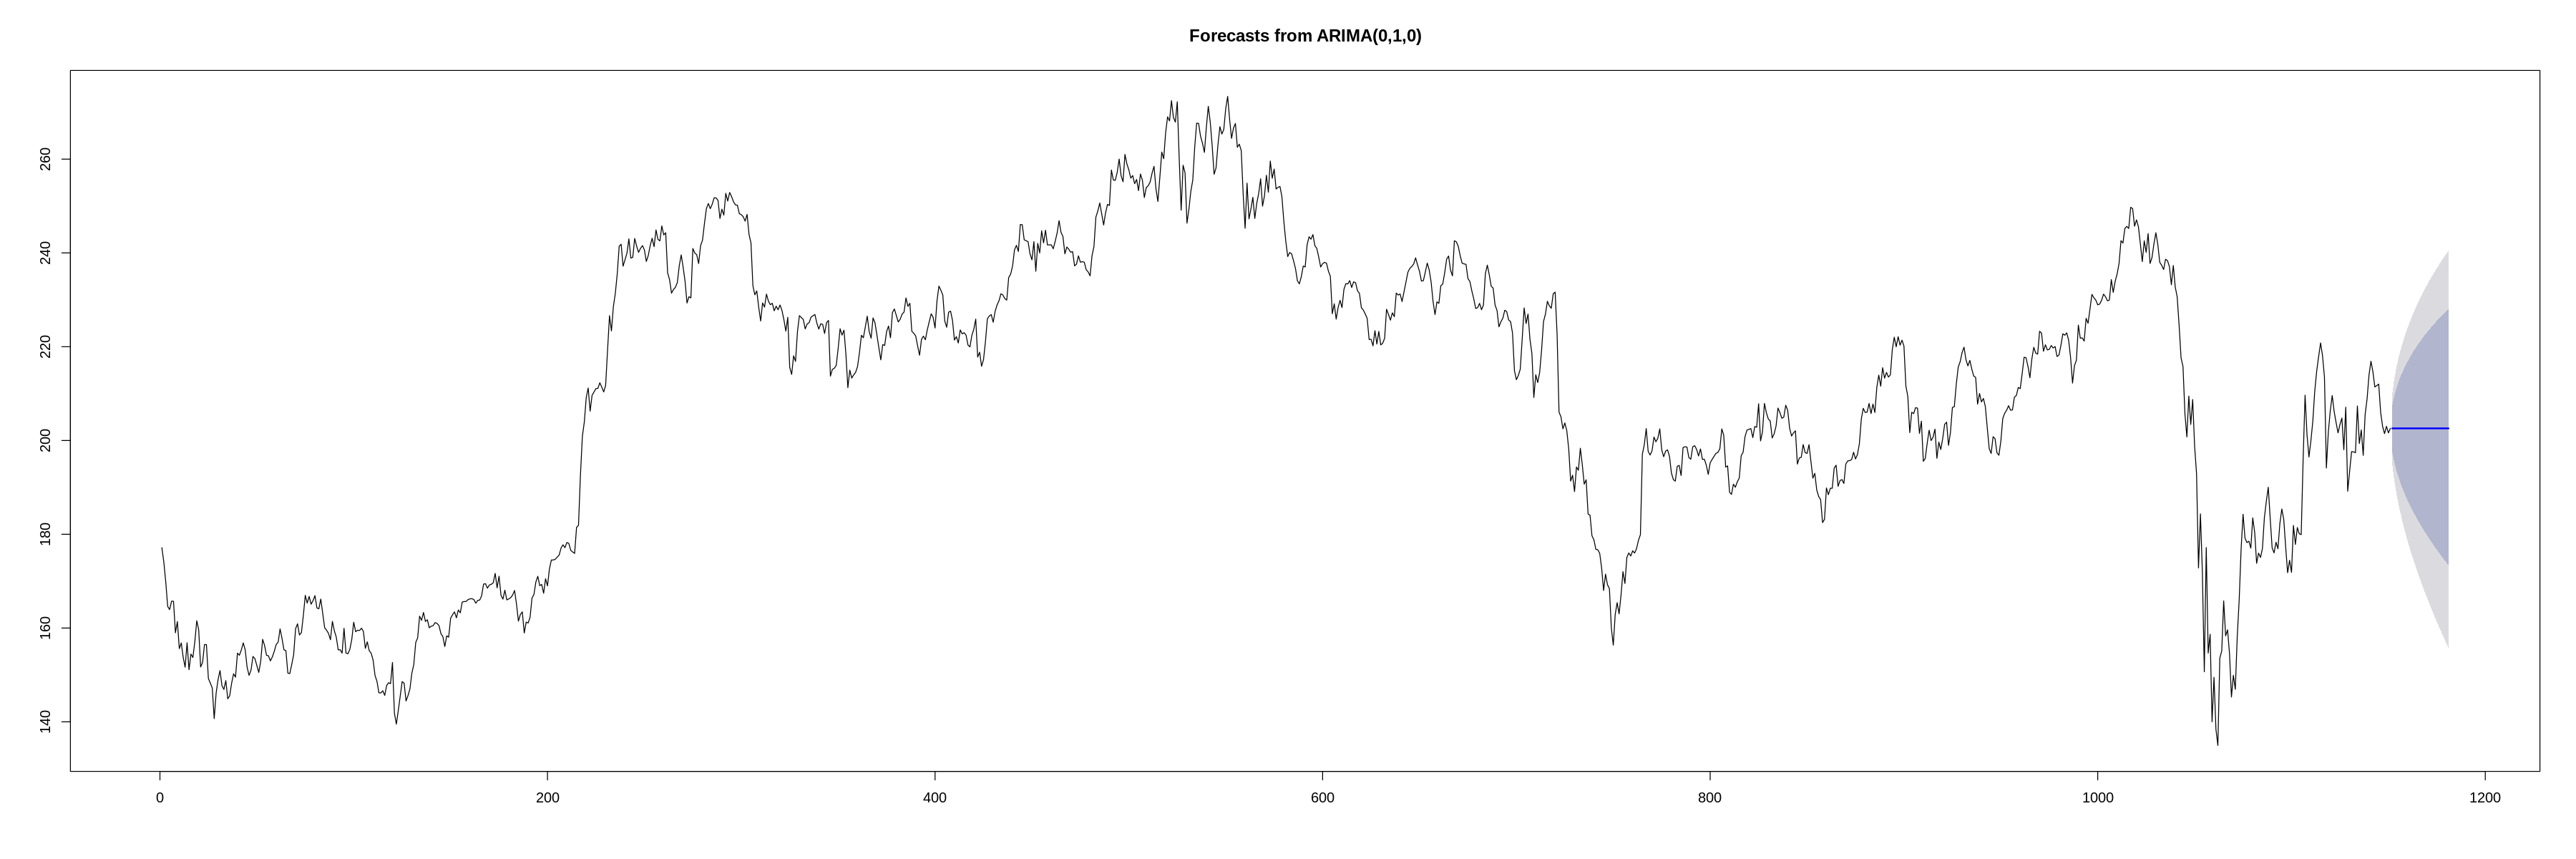

In [ ]:
modelfit <- auto.arima(Cl(gsachs), lambda = "auto")
modelfit
price_forecast <- forecast(modelfit, h=30)
options(repr.plot.width = 30, repr.plot.height = 10)
plot(price_forecast) # Blue Line = represents the mean of prediction

### **Forecasting Using K Nearest Neighbours**

In [ ]:
gsachs_df <- data.frame(date = index(gsachs), close = as.numeric(gsachs[,'GS.Close']))
head(gsachs_df)
tail(gsachs_df)

,date,close
,<date>,<dbl>
1,2016-01-04,177.14
2,2016-01-05,174.09
3,2016-01-06,169.84
4,2016-01-07,164.62
5,2016-01-08,163.94
6,2016-01-11,165.73


,date,close
,<date>,<dbl>
1146,2020-07-22,206.00
1147,2020-07-23,203.02
1148,2020-07-24,201.47
1149,2020-07-27,203.02
1150,2020-07-28,201.62
1151,2020-07-29,202.58


In [ ]:
gsachs_knn <- knn_forecasting(gsachs_df$close, h = 30, lags = 1:30, k = 40, msas = "MIMO")

ro <- rolling_origin(predknn)  #accuracy
print(ro$global_accu)          #accuracy

    RMSE      MAE     MAPE 
9.488615 7.762295 3.788786 


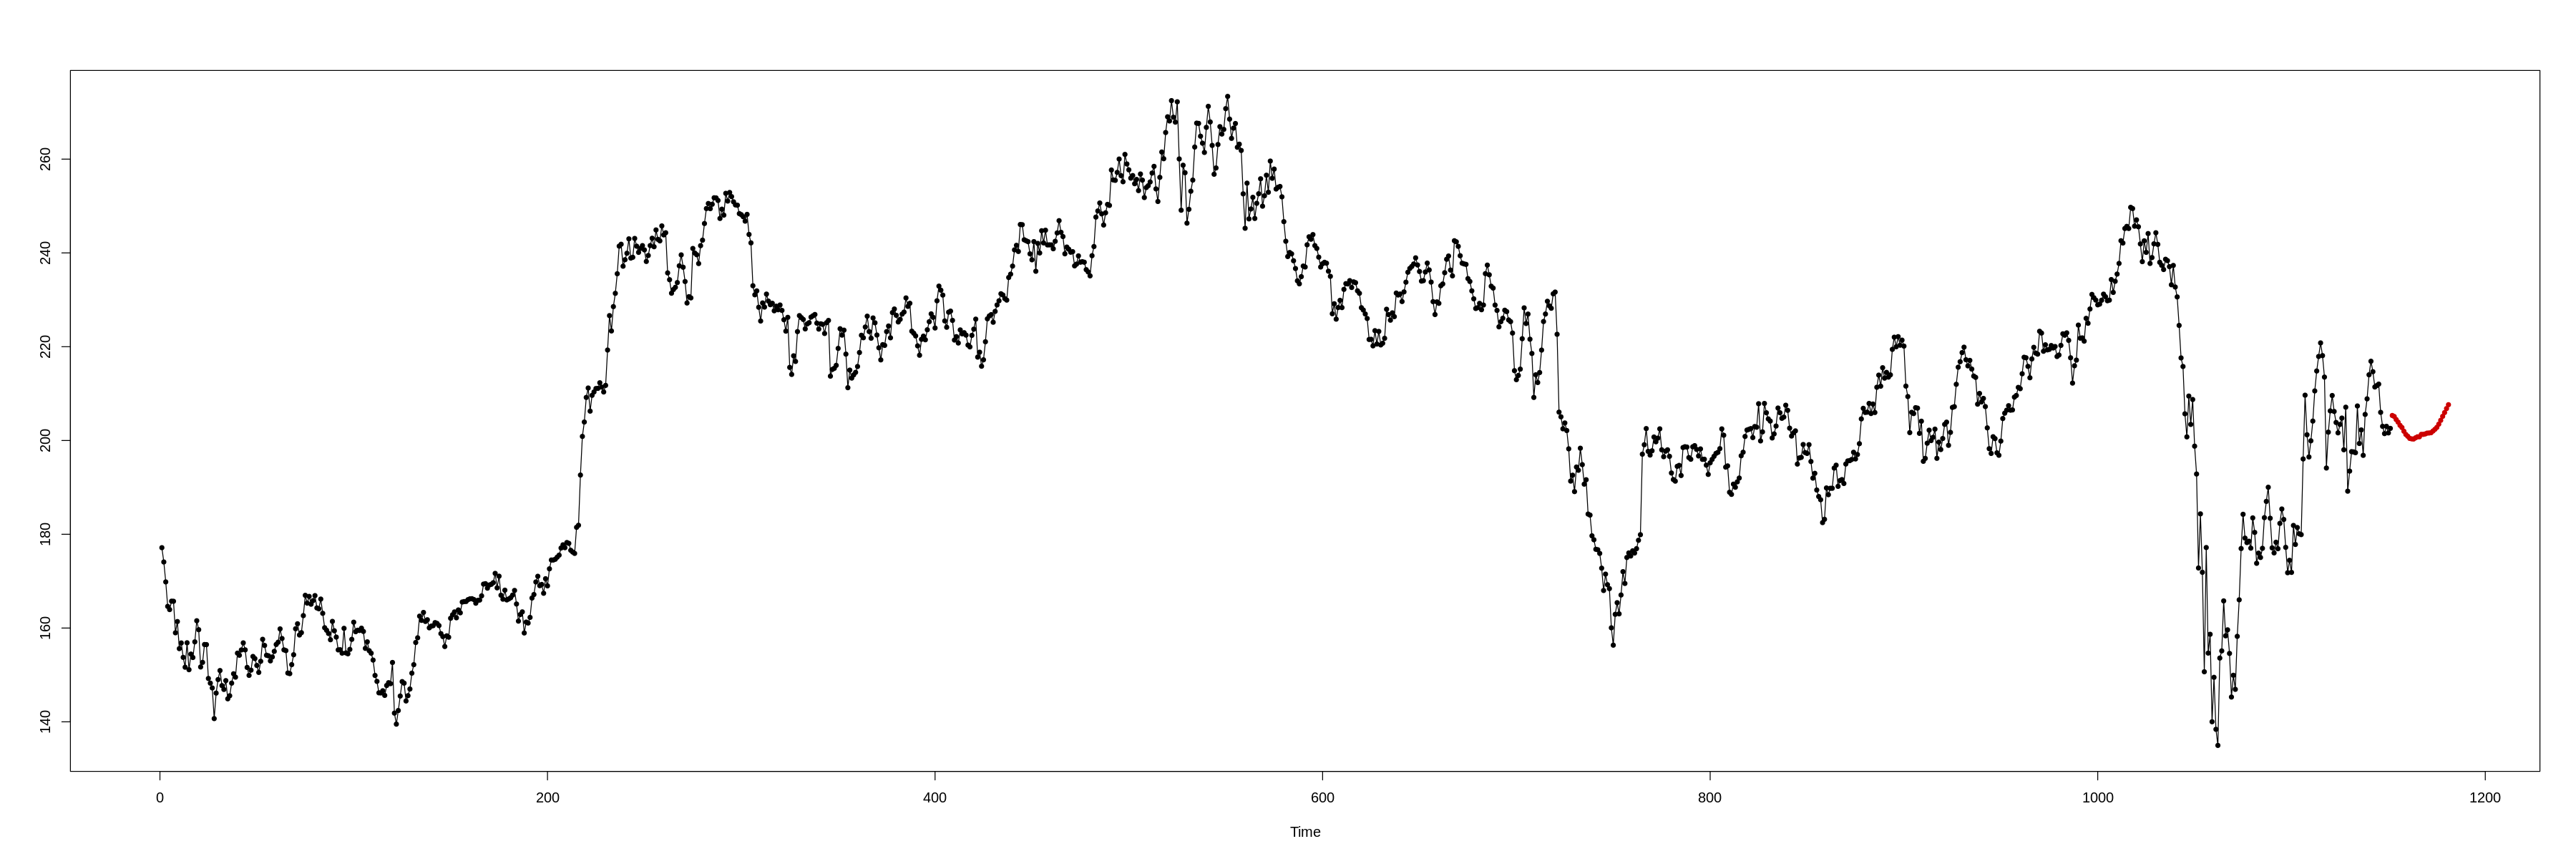

In [ ]:
plot(gsachs_knn)

### **Forecasting using Feed Foward Neural network**

In [ ]:
alpha <- 1.5^(-10)
hn <- length(Cl(gsachs))/(alpha*(length(Cl(gsachs))+30)) # calculating number of hidden nodes

In [ ]:
lambda <- BoxCox.lambda(Cl(gsachs))
dnn_pred <- nnetar(Cl(gsachs), size= hn, lambda = lambda) # Single layer dnn

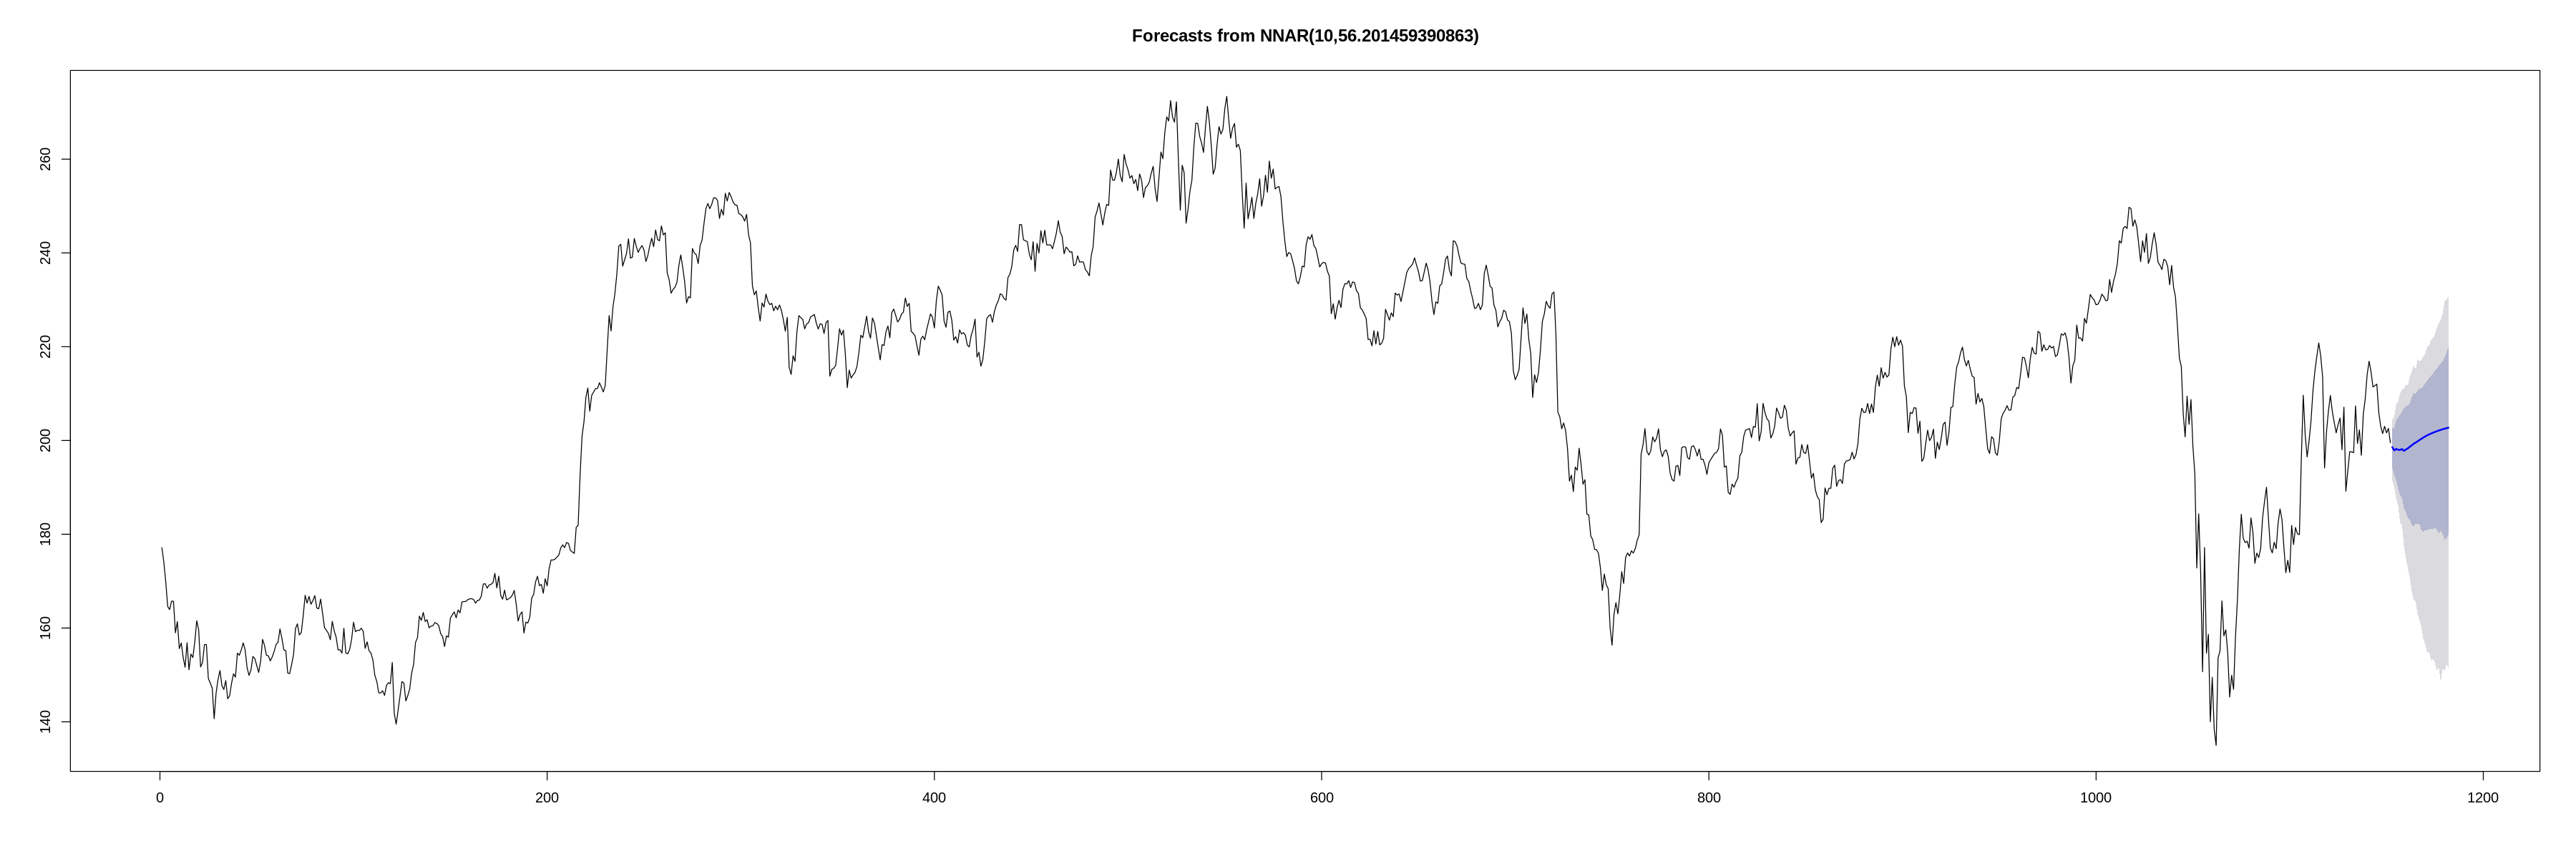

In [ ]:
dnn_forecast <- forecast(dnn_pred, h= 30, PI = TRUE)
options(repr.plot.width = 30, repr.plot.height = 10)
plot(dnn_forecast)